# 4:2 MENT

In [1]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import proplot as pplt
import psdist as ps
import psdist.visualization as psv
from tqdm.notebook import tqdm
from tqdm.notebook import trange

import ment

In [2]:
pplt.rc["cmap.discrete"] = False
pplt.rc["cmap.sequential"] = "viridis"
pplt.rc["figure.facecolor"] = "white"
pplt.rc["grid"] = False

Settings:

In [3]:
dist_name = "gaussian_mixture"
ndim = 6
n_meas = 9
n_bins = 50
xmax = 3.5
seed = 12345

Define the source distribution.

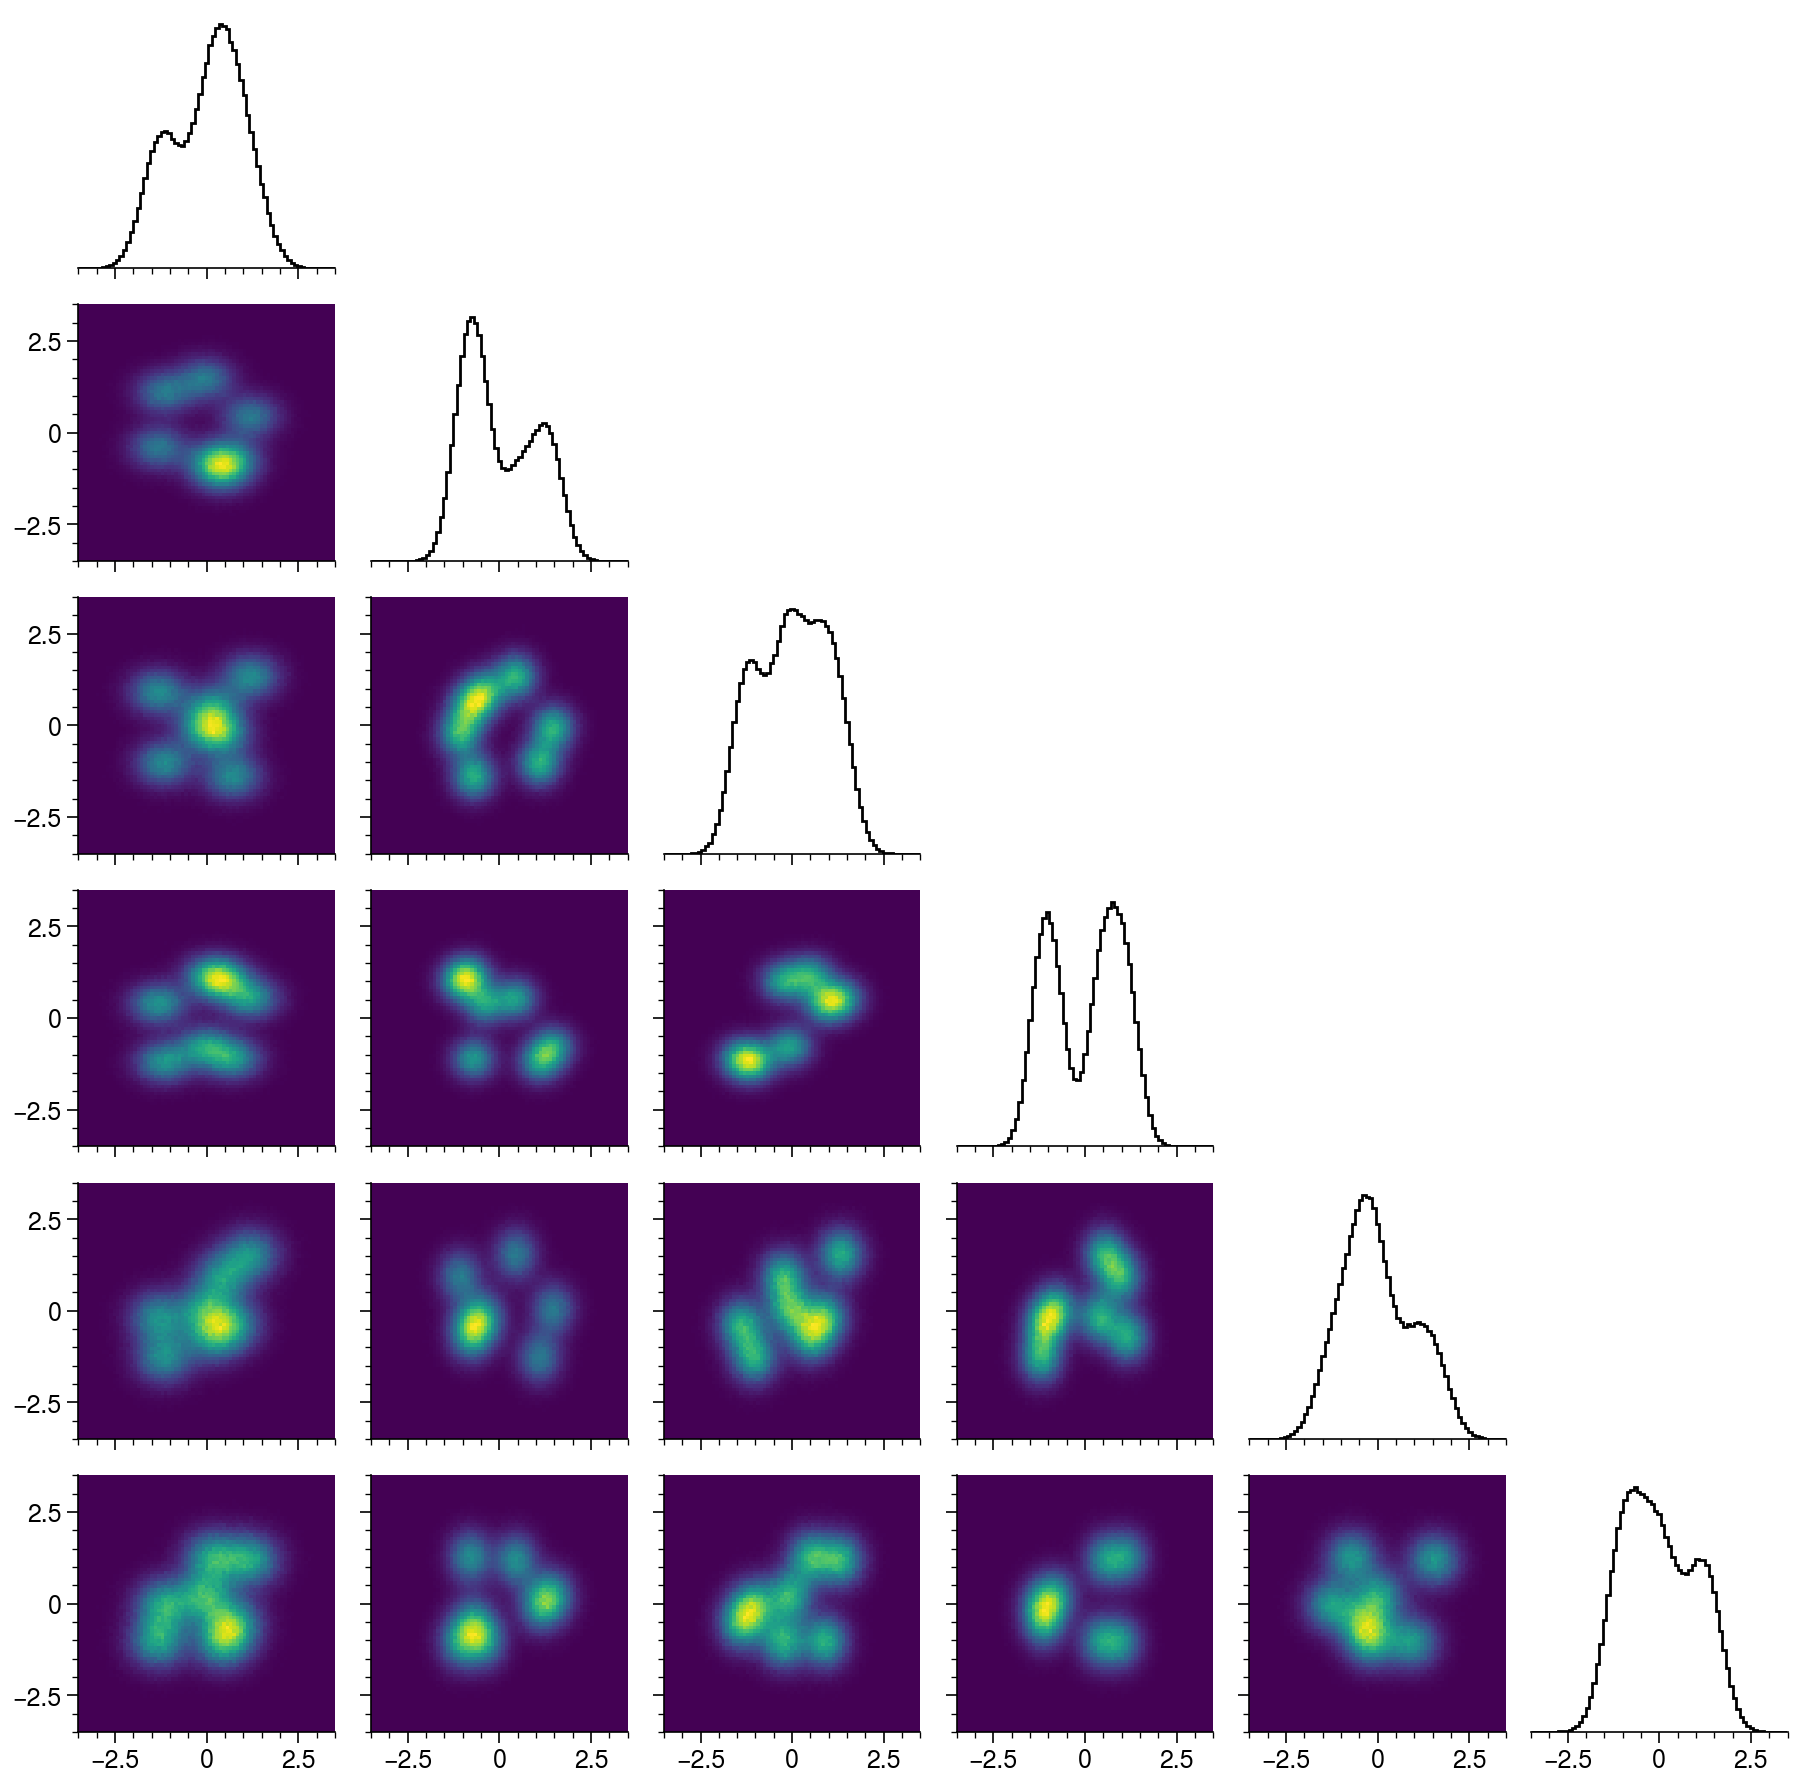

In [4]:
dist = ment.dist.get_dist(
    dist_name, ndim=ndim, seed=seed, 
    # scale=1.0,
)
x_true = dist.sample(1_000_000)

limits = ndim * [(-xmax, xmax)]

grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.5))
grid.plot_points(x_true, limits=limits, bins=75, mask=False);

Generate data.

In [5]:
# ## Create transforms: rotations in x-x' and y-y'.
# phase_advances_x = np.linspace(0.0, np.pi, int(np.sqrt(n_meas)), endpoint=False)
# phase_advances_y = phase_advances_x
# transfer_matrices = []
# for mux in phase_advances_x:
#     for muy in phase_advances_y:
#         matrix = np.eye(ndim)
#         matrix[0:2, 0:2] = ment.sim.rotation_matrix(mux)
#         matrix[2:4, 2:4] = ment.sim.rotation_matrix(muy)
#         transfer_matrices.append(matrix)


## Create transforms (random phase advances)
rng = np.random.default_rng(seed)
phase_advances = rng.uniform(0.0, np.pi, size=(n_meas, 2))
transfer_matrices = []
for (mux, muy) in phase_advances:
    matrix = np.eye(ndim)
    matrix[0:2, 0:2] = ment.sim.rotation_matrix(mux)
    matrix[2:4, 2:4] = ment.sim.rotation_matrix(muy)
    transfer_matrices.append(matrix)


transforms = []
for matrix in transfer_matrices:
    transform = ment.sim.LinearTransform(matrix)
    transforms.append(transform)

# Create diagnostics (x-y histogram).
axis_proj = (0, 2)
bin_edges = len(axis_proj) * [np.linspace(-xmax, xmax, n_bins + 1)]

diagnostics = []
for transform in transforms:
    diagnostic = ment.diag.HistogramND(axis=(0, 2), bin_edges=bin_edges)
    diagnostics.append([diagnostic])
diagnostics

# Generate measurement data.
measurements = []
for index, transform in enumerate(transforms):
    u = transform(x_true)
    measurements.append([diagnostic(u) for diagnostic in diagnostics[index]])

Create reconstruction model.

In [12]:
# Prior distribution
prior = ment.UniformPrior(ndim=ndim, scale=(2.0 * xmax))

# Sampler
samp_grid_res = 10
samp_noise = 1.0
samp_grid_shape = ndim * [samp_grid_res]
samp_grid_limits = limits

sampler = ment.samp.GridSampler(
    grid_limits=samp_grid_limits, 
    grid_shape=samp_grid_shape,
    noise=samp_noise,
)

integration_limits = [limits[i] for i in range(ndim) if i not in axis_proj]
integration_limits = [[integration_limits],] * len(transforms)

# MENT solver
model = ment.MENT(
    ndim=ndim,
    measurements=measurements,
    transforms=transforms,
    diagnostics=diagnostics,
    prior=prior,
    interpolation=dict(method="linear"),
    
    sampler=sampler,
    n_samples=1_000_000,
    
    integration_limits=integration_limits,
    integration_size=(10 ** 4), 
    integration_batches=1,

    mode="integrate",
    verbose=True,
)

learning_rate = 0.90
n_epochs = 2

epoch = -1


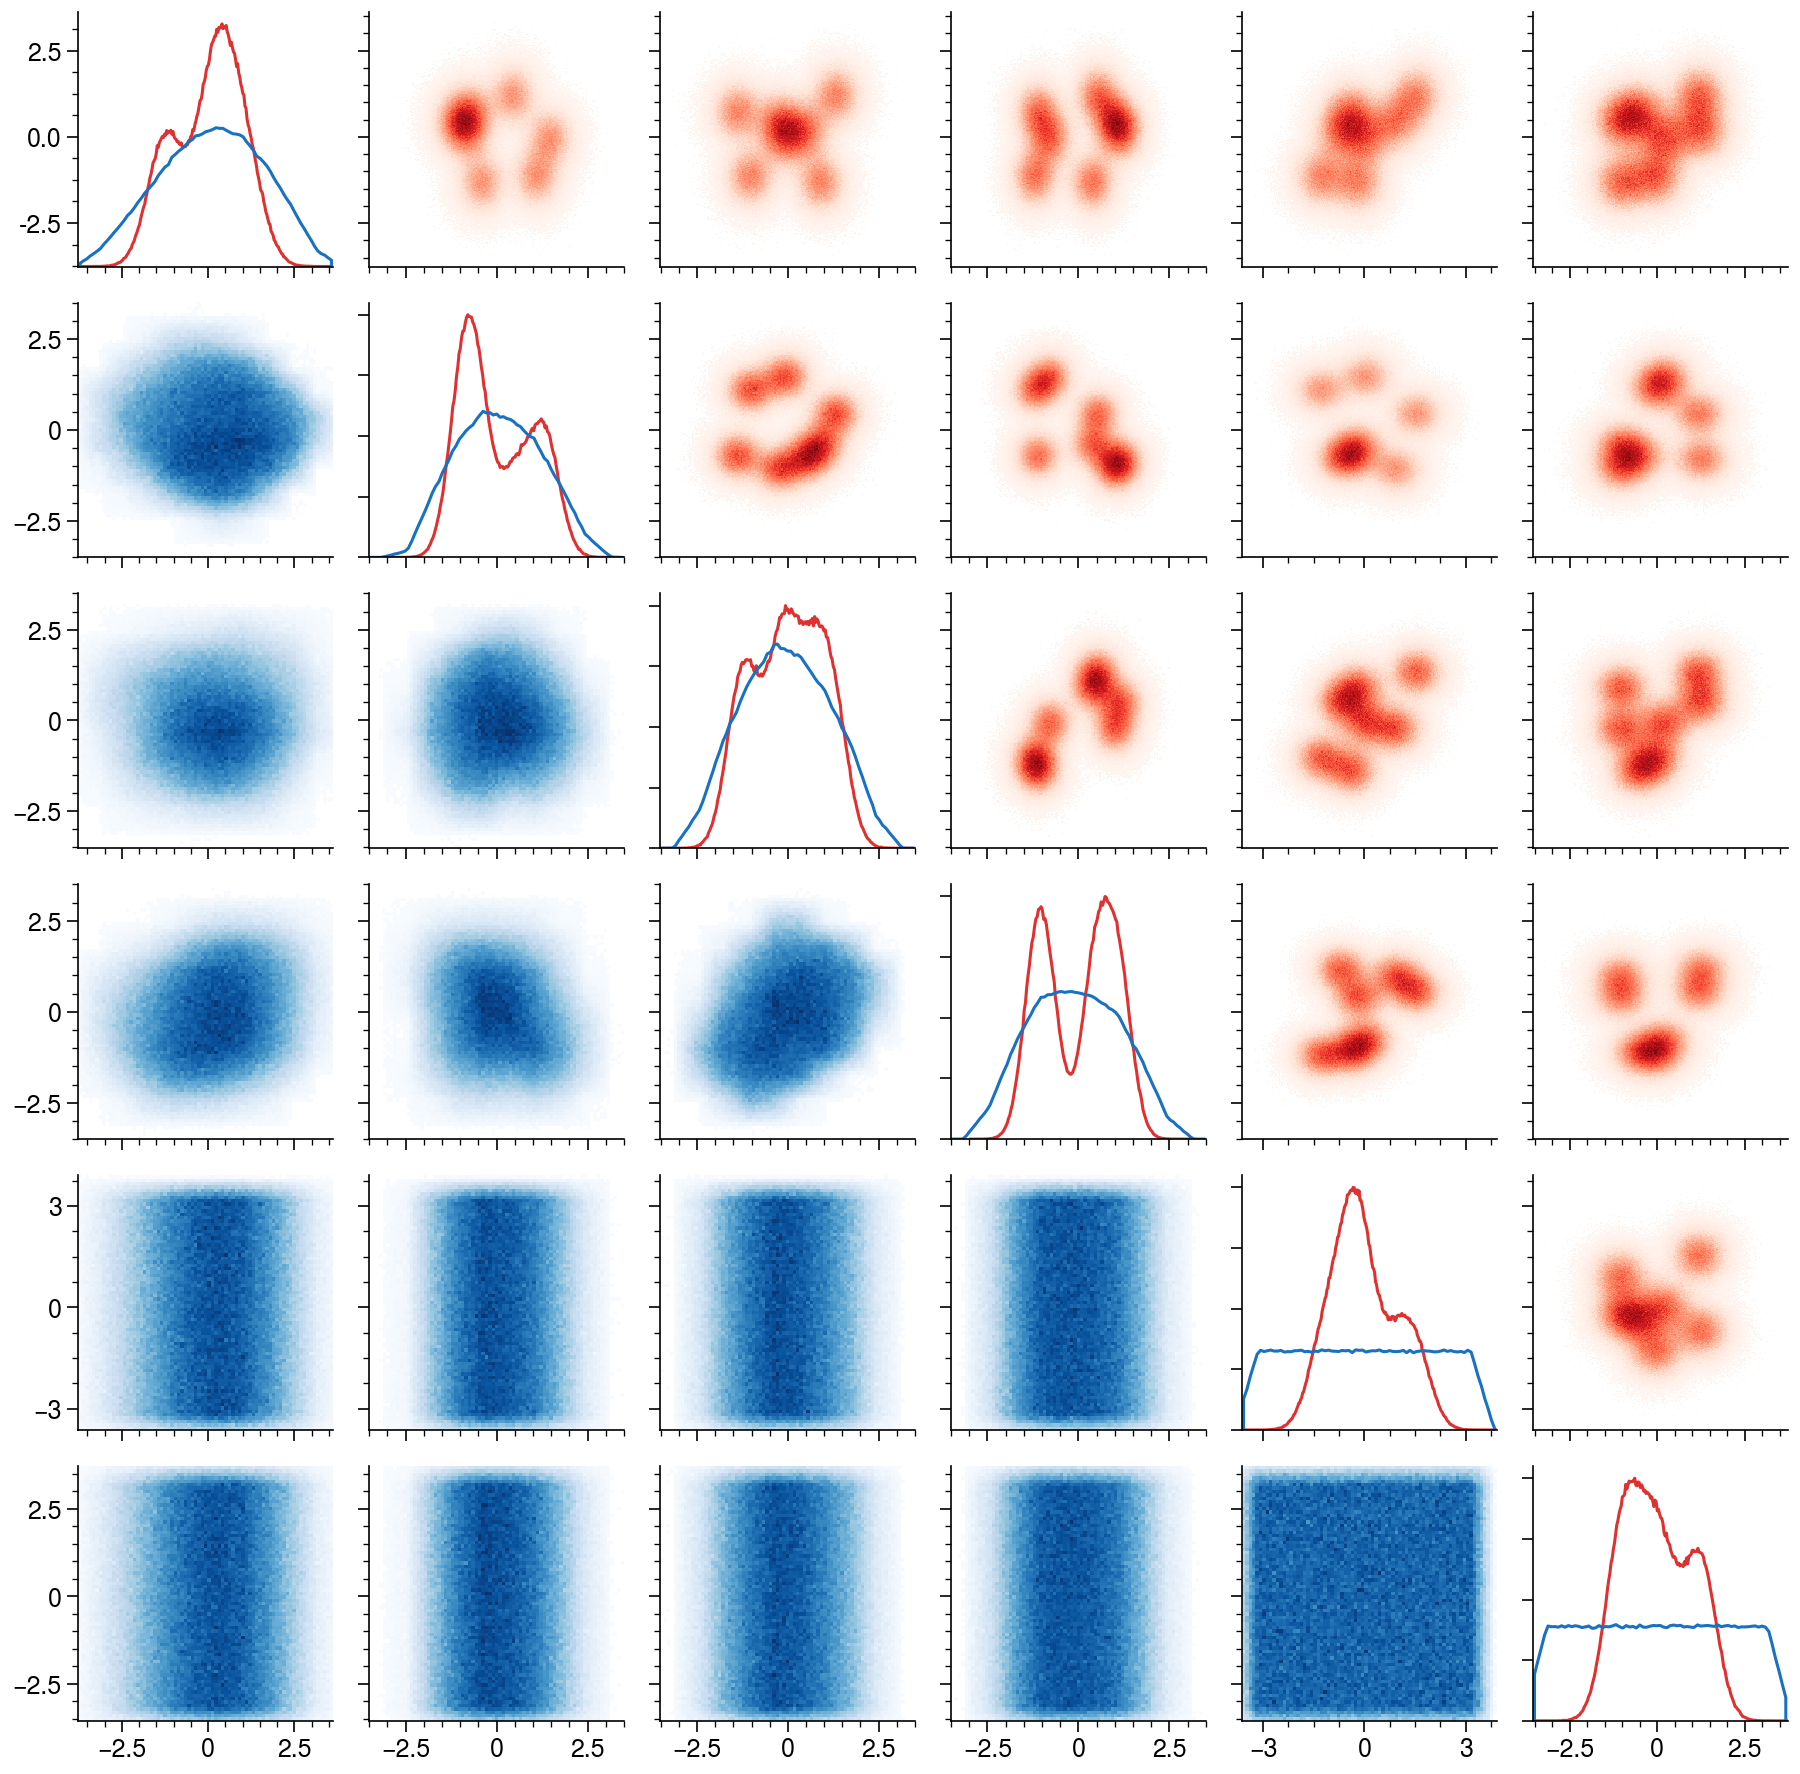

epoch = 0
index=0
index=1
index=2
index=3
index=4
index=5
index=6
index=7
index=8
time = 194.638


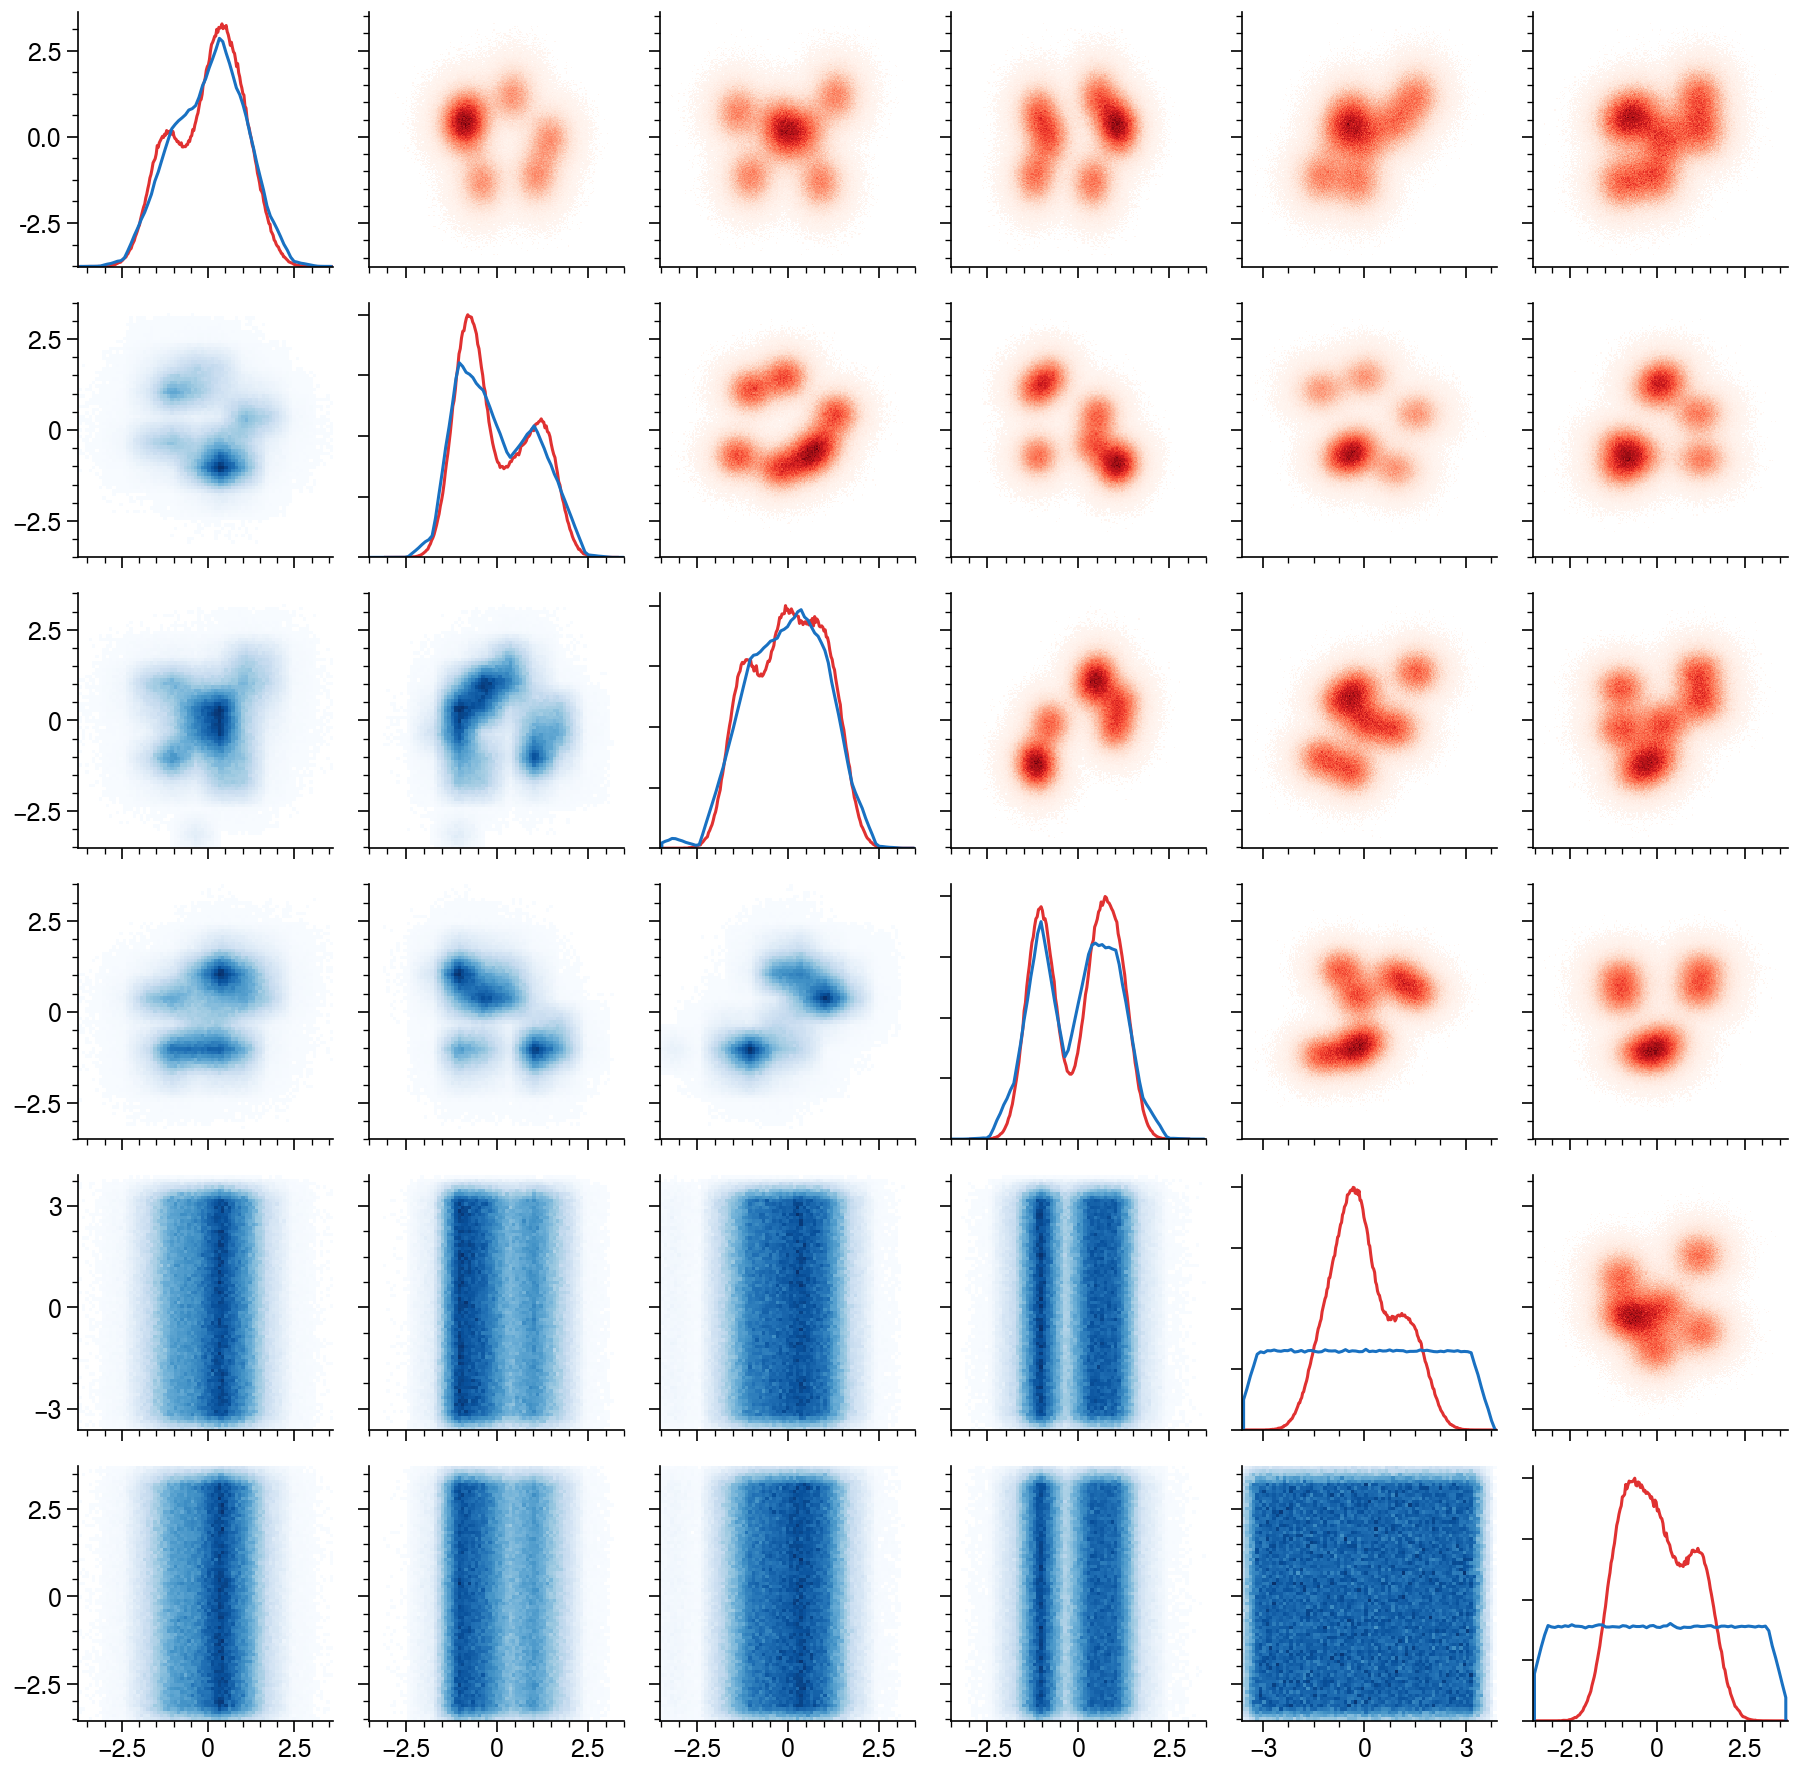

epoch = 1
index=0
index=1
index=2
index=3
index=4
index=5
index=6
index=7
index=8
time = 384.860


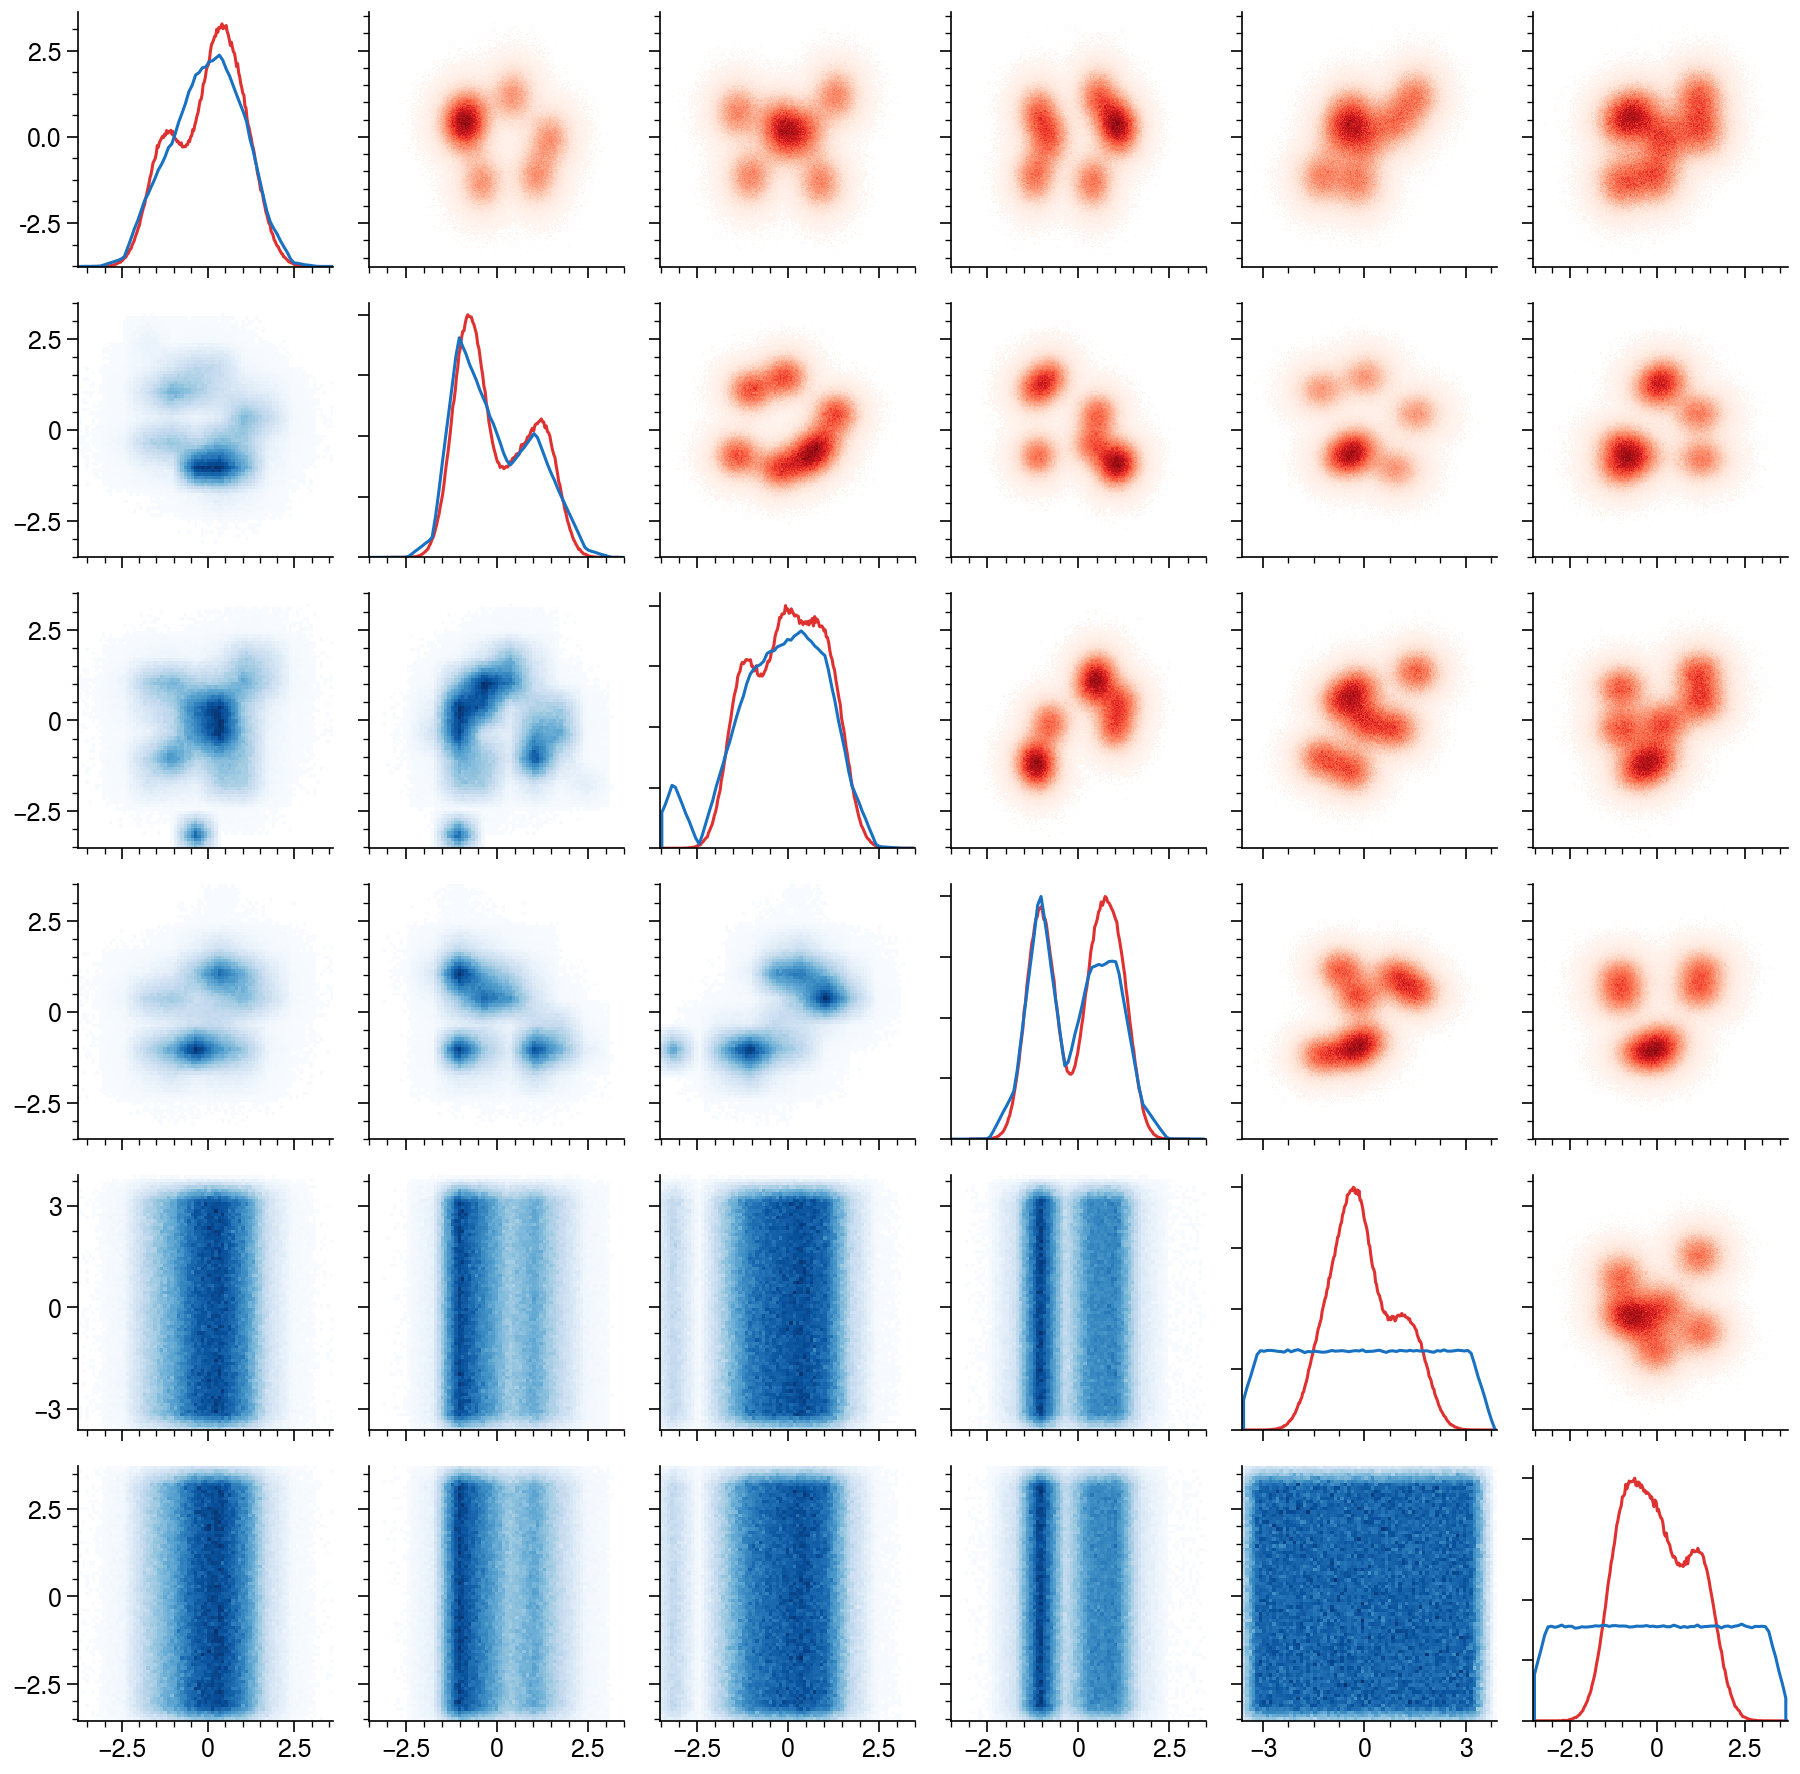

In [13]:
start_time = time.time()

for epoch in range(-1, n_epochs):
    print(f"epoch = {epoch}")
    if epoch >= 0:
        model.gauss_seidel_step(lr=learning_rate)
        print("time = {:0.3f}".format(time.time() - start_time))

    x = model.sample(1_000_000)
    
    grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.5), corner=False)
    kws = dict(limits=limits, bins=75, mask=True)
    grid.plot_points(
        x_true, 
        lower=False, 
        diag_kws=dict(kind="line", color="red8", lw=1.1),
        cmap=pplt.Colormap("reds"),
    )
    grid.plot_points(
        x, 
        upper=False, 
        diag_kws=dict(kind="line", color="blue8", lw=1.1), 
        cmap=pplt.Colormap("blues"),
        **kws
    )
    plt.show()

In [17]:
index = 0
meas = measurements[index][0].copy()
pred = model.simulate(index=index, diag_index=0)

0


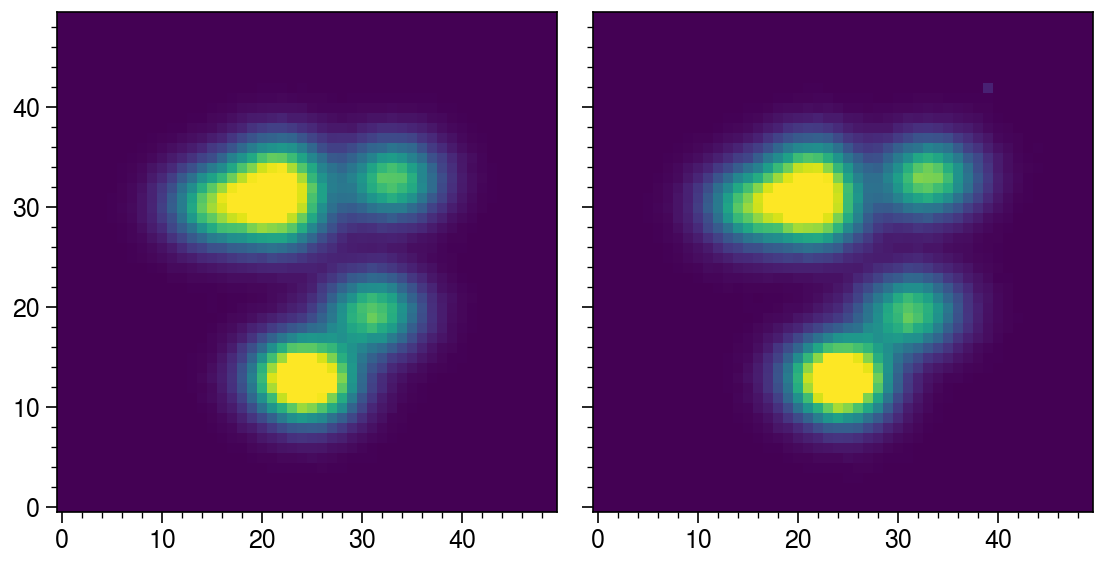

1


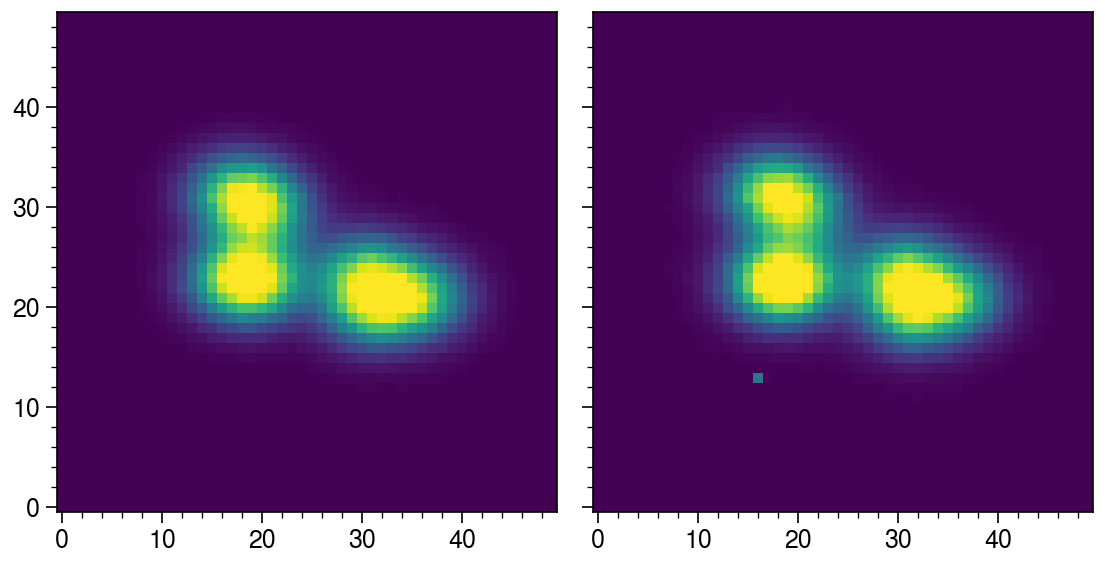

2


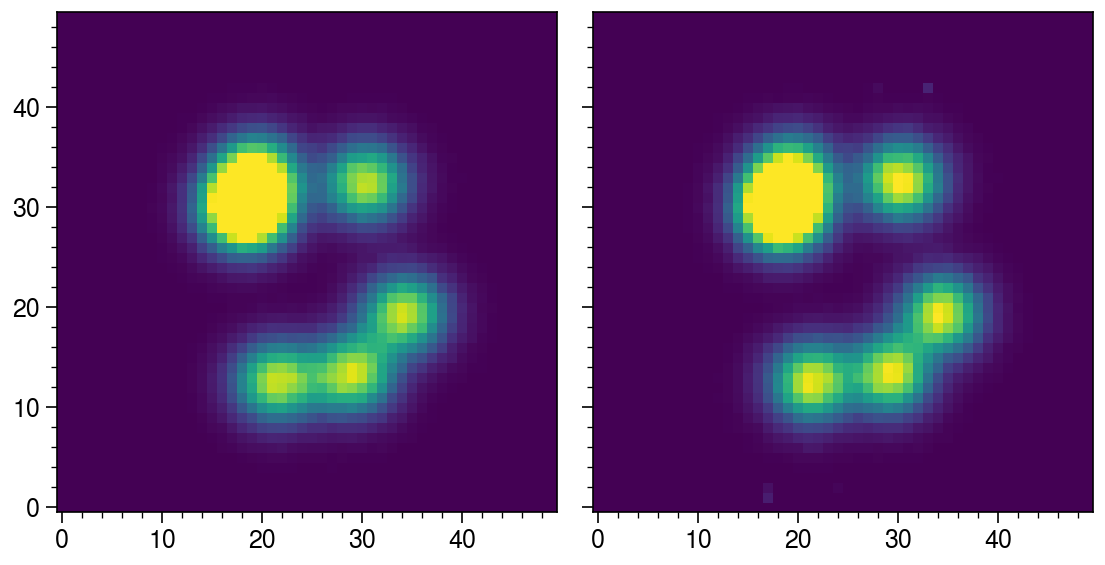

3


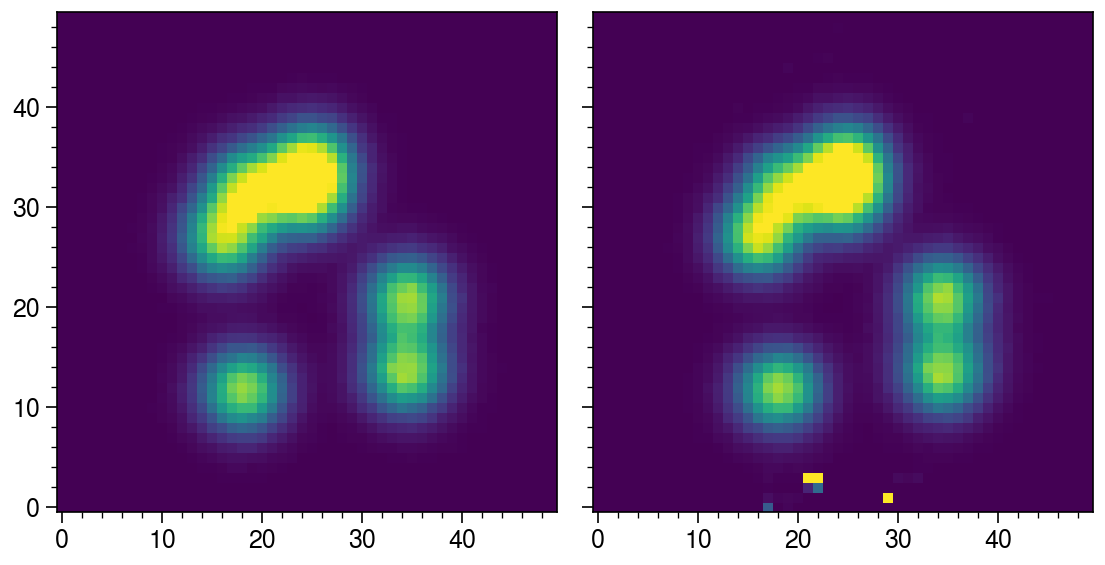

4


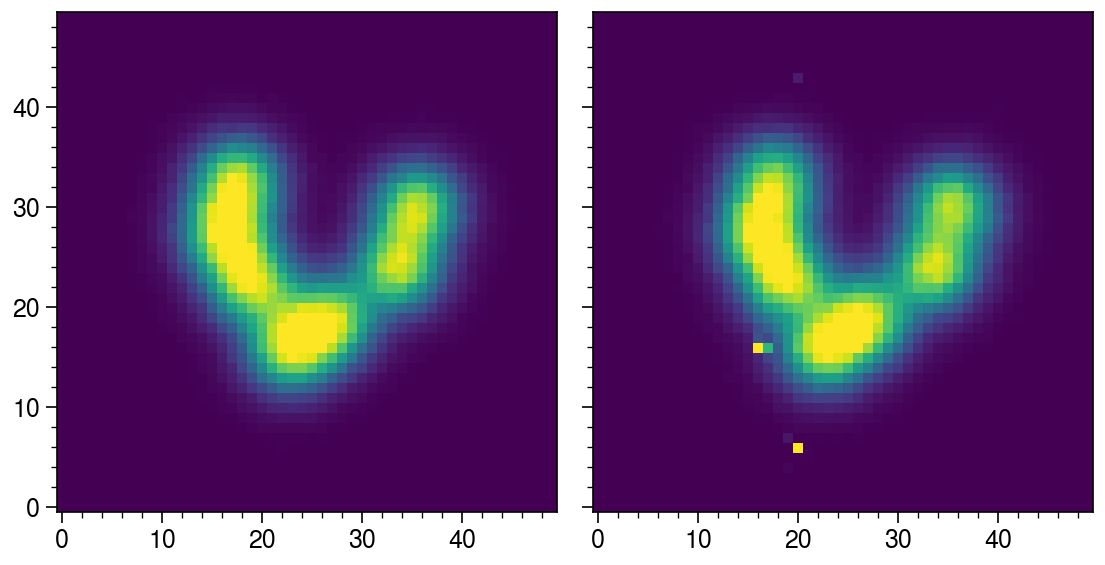

5


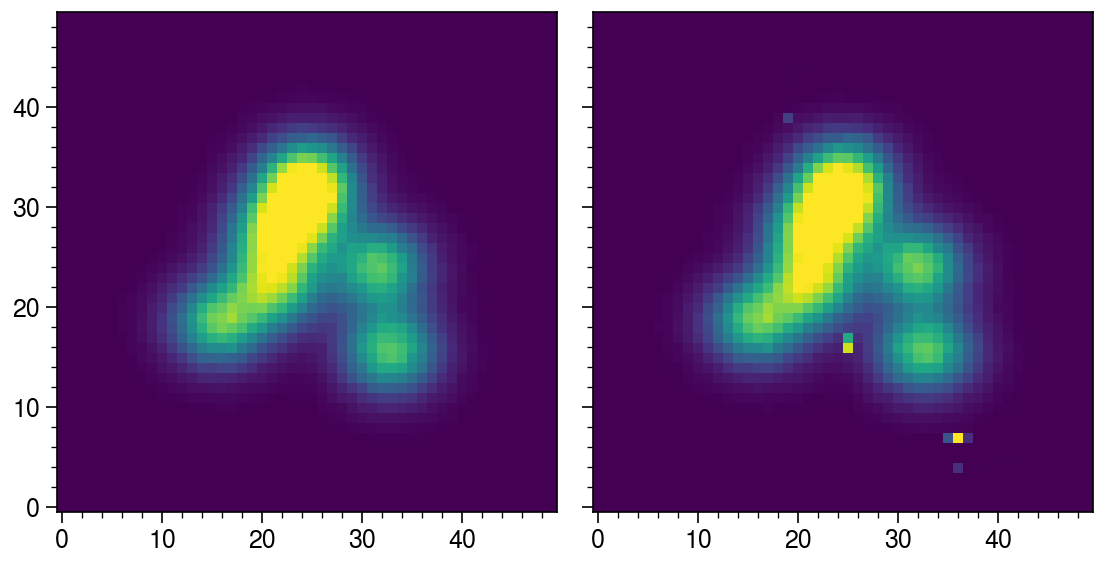

6


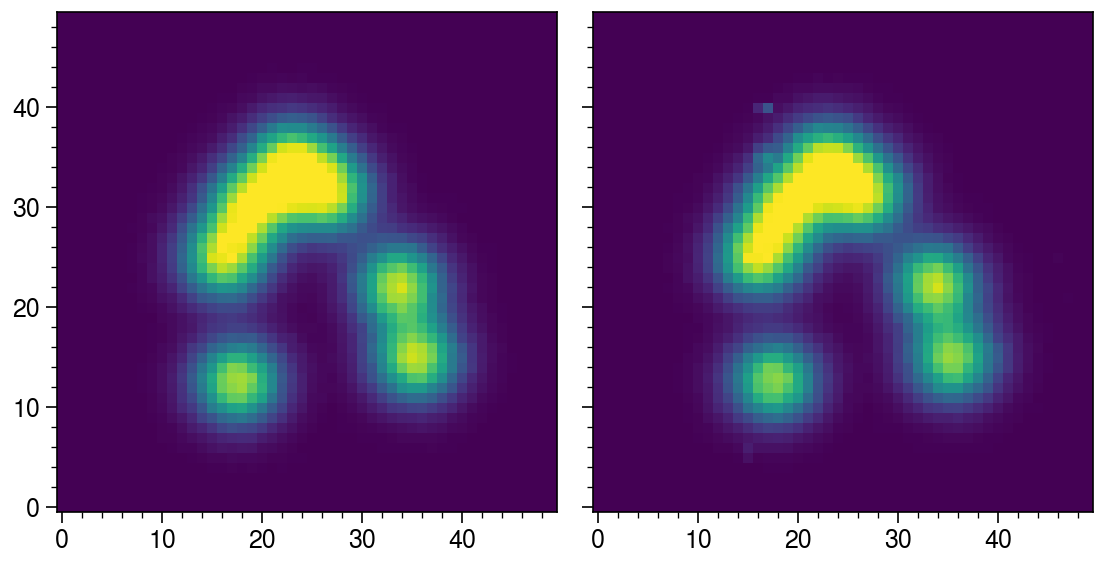

7


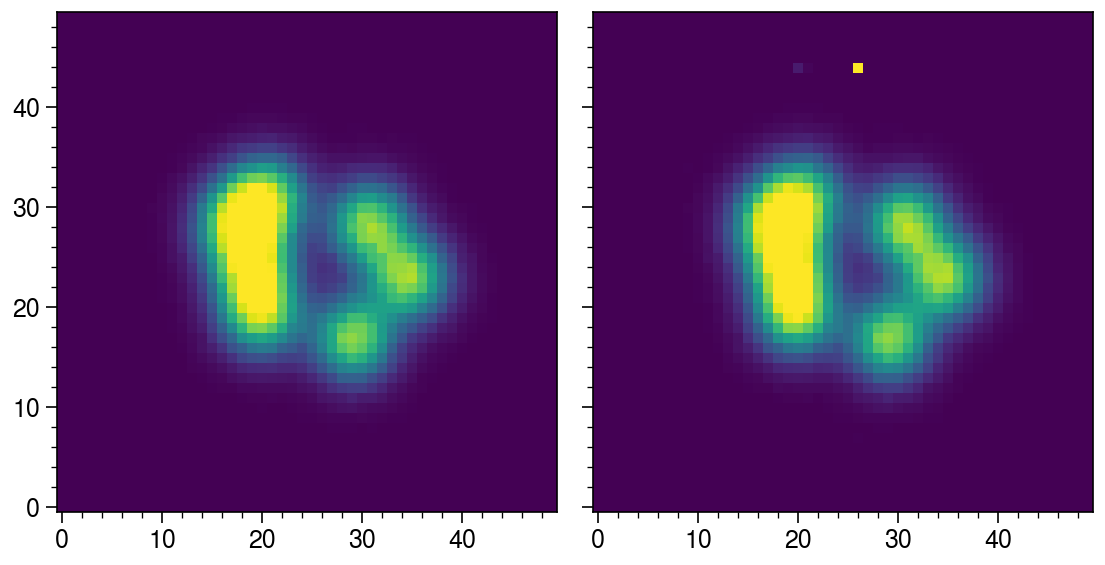

8


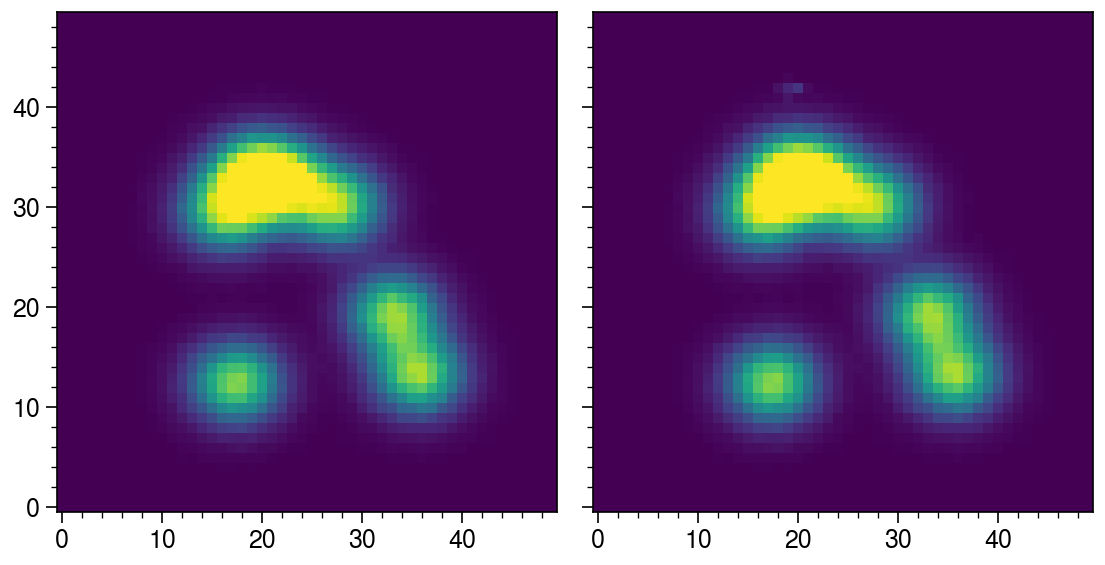

In [33]:
for index in range(n_meas):
    print(index)
    
    meas = measurements[index][0].copy()
    pred = model.simulate(index=index, diag_index=0)
    
    fig, axs = pplt.subplots(ncols=2)
    robust = True
    axs[0].pcolormesh(meas.T, robust=robust)
    axs[1].pcolormesh(pred.T, robust=robust)
    plt.show()

In [21]:
time_per_iteration = (194.638 / 9)
time_per_iteration

21.626444444444445

In [30]:
_n_meas = 15
_n_epochs = 4
_total_time = _n_meas * time_per_iteration * _n_epochs
print(f"total time = {_total_time / 60.0} [min]")

total time = 21.62644444444444 [min]
